### Import relevant libraries and read in and prepare the data

In [1]:
# Import relevant libraries

# For data manipulation
import pandas as pd

# For model building and selection
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Save model
import pickle

In [2]:
# Read in data
df = pd.read_csv("../data/processed/fingerprints_pic50.csv")

In [3]:
# Inspect original dataframe
df.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.869666
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.882397
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.008774
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.022276
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.950782


##### Prediction and target variables

In [4]:
# Prediction (X) and target (y) variables
X = df.drop(columns="pIC50")
y = df["pIC50"]

print(f"Shape of X: {X.shape} \nShape of y: {y.shape}")

Shape of X: (148, 881) 
Shape of y: (148,)


In [5]:
# Only keep features that show a degree of variance
selection = VarianceThreshold(threshold=(0.8 * (1 - 0.8))) # Formula for binary features   
X = selection.fit_transform(X)

In [6]:
# Check how many predictors retained
print(f"Number of feature space retained: {X.shape[1]}")

Number of feature space retained: 183


##### Train test split

In [7]:
# Train test split (80/20 split)
# Using cross-validation during model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### Model building

In [8]:
# Define pipeline (including only the model itsel)
pipeline = Pipeline([
    ("regressor", RandomForestRegressor(random_state=42))
])

In [9]:
# Define parameter grid for the regressor
param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [5, 10, 20],
    "regressor__min_samples_split": [5, 10]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error", # Discourage overfitting
    cv=5, # Use 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the pipeline to the pre-selected training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV] END regressor__max_depth=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__max_depth=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__max_depth=5, regressor__min_samples_split=5, regressor__n_estimators=200; total time=   1.1s
[CV] END regressor__max_depth=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.7s
[CV] END regressor__max_depth=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.6s
[CV] END regressor__max_depth=5, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.7s
[CV] END regressor__max_depth=5, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__max_depth=5, regressor__min_samples_split=5, regressor__n_estimators=200; total time=   1.2s
[CV] END regressor__max_depth=5, regressor__min_samples_split=10, regressor__n_estimators=100; 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 10, 20],
                         'regressor__min_samples_split': [5, 10],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

### Evaluate model

In [10]:
# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Predictions on test set
y_pred = best_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

Best Parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Mean Squared Error: 0.353
R² Score: 0.728


In [11]:
# Training predictions to check for overfitting
y_train_pred = grid_search.best_estimator_.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training MSE: {train_mse:.3f}, Training R²: {train_r2:.3f}")

Training MSE: 0.146, Training R²: 0.818


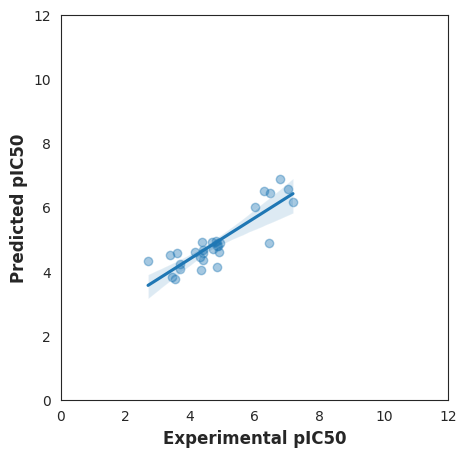

In [12]:
# Plot actual vs. predicted pIC50 values
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={"alpha":0.4})
ax.set_xlabel("Experimental pIC50", fontsize="large", fontweight="bold")
ax.set_ylabel("Predicted pIC50", fontsize="large", fontweight="bold")
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show()

### Save model

In [13]:
# Save the model
with open("../models/random_forest.pkl", "wb") as file:
    pickle.dump(grid_search.best_estimator_, file)